In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from statsmodels.tsa.api import SimpleExpSmoothing
import time
import warnings
warnings.filterwarnings('ignore')

# Read data

In [2]:
SalesTrain = pd.read_csv("data/sales_train_evaluation.csv")
SellPrices = pd.read_csv("data/sell_prices.csv")
Calendar = pd.read_csv("data/calendar.csv")

In [3]:
SalesTrain.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1947)

In [4]:
DateColumns = [date for date in SalesTrain.columns if 'd_' in date] # Get date related columns
Train_X = SalesTrain[DateColumns[:1913]]
Test_X = SalesTrain[DateColumns]

# Performance metrics

In [5]:
from typing import Union

class WRMSSEFunction(object):

    def __init__(self, Data_Train: pd.DataFrame, Data_Validation: pd.DataFrame, Calendar: pd.DataFrame, SellPrices: pd.DataFrame):
        y_Train = Data_Train.loc[:, Data_Train.columns.str.startswith('d_')]
        y_Train_Columns = y_Train.columns.tolist()
        Weight_Columns = y_Train.iloc[:, -28:].columns.tolist()

        Data_Train['all_id'] = 0  # for lv1 aggregation

        ID_Columns = Data_Train.loc[:, ~Data_Train.columns.str.startswith('d_')].columns.tolist()
        Data_Validation_Columns = Data_Validation.loc[:, Data_Validation.columns.str.startswith('d_')].columns.tolist()

        if not all([c in Data_Validation.columns for c in ID_Columns]):
            Data_Validation = pd.concat([Data_Train[ID_Columns], Data_Validation], axis=1, sort=False)

        self.Data_Train = Data_Train
        self.Data_Validation = Data_Validation
        self.Calendar = Calendar
        self.SellPrices = SellPrices

        self.Weight_Columns = Weight_Columns
        self.ID_Columns = ID_Columns
        self.Data_Validation_Columns = Data_Validation_Columns

        Data_Weight = self.Get_the_Weights()

        self.ID_lists = (
            'all_id',
            'state_id',
            'store_id',
            'cat_id',
            'dept_id',
            ['state_id', 'cat_id'],
            ['state_id', 'dept_id'],
            ['store_id', 'cat_id'],
            ['store_id', 'dept_id'],
            'item_id',
            ['item_id', 'state_id'],
            ['item_id', 'store_id']
        )

        for i, id in enumerate(tqdm(self.ID_lists)):
            y_Train = Data_Train.groupby(id)[y_Train_Columns].sum()
            Scales = []
            for _, row in y_Train.iterrows():
                List1 = row.values[np.argmax(row.values != 0):]
                Scales.append(((List1[1:] - List1[:-1]) ** 2).mean())
            setattr(self, f'lv{i + 1}_Scales', np.array(Scales))
            setattr(self, f'lv{i + 1}_Data_Train', y_Train)
            setattr(self, f'lv{i + 1}_Data_Validation', Data_Validation.groupby(id)[Data_Validation_Columns].sum())

            Weight_l = Data_Weight.groupby(id)[Weight_Columns].sum().sum(axis=1)
            setattr(self, f'lv{i + 1}_weight', Weight_l / Weight_l.sum())

    def Get_the_Weights(self) -> pd.DataFrame:
        day_to_week = self.Calendar.set_index('d')['wm_yr_wk'].to_dict()
        Data_Weight = self.Data_Train[['item_id', 'store_id'] + self.Weight_Columns].set_index(['item_id', 'store_id'])
        Data_Weight = Data_Weight.stack().reset_index().rename(columns={'level_2': 'd', 0: 'value'})
        Data_Weight['wm_yr_wk'] = Data_Weight['d'].map(day_to_week)

        Data_Weight = Data_Weight.merge(self.SellPrices, how='left', on=['item_id', 'store_id', 'wm_yr_wk'])
        Data_Weight['value'] = Data_Weight['value'] * Data_Weight['sell_price']
        Data_Weight = Data_Weight.set_index(['item_id', 'store_id', 'd']).unstack(level=2)['value']
        Data_Weight = Data_Weight.loc[zip(self.Data_Train.item_id, self.Data_Train.store_id), :].reset_index(drop=True)
        Data_Weight = pd.concat([self.Data_Train[self.ID_Columns], Data_Weight], axis=1, sort=False)
        return Data_Weight

    def RMSSE(self, FCAST: pd.DataFrame, lv: int) -> pd.Series:
        y_Validation = getattr(self, f'lv{lv}_Data_Validation')
        Score = ((y_Validation - FCAST) ** 2).mean(axis=1)
        Scales = getattr(self, f'lv{lv}_Scales')
        return (Score / Scales).map(np.sqrt)

    def score(self, FCAST: Union[pd.DataFrame, np.ndarray]) -> float:
        assert self.Data_Validation[self.Data_Validation_Columns].shape == FCAST.shape

        if isinstance(FCAST, np.ndarray):
            FCAST = pd.DataFrame(FCAST, columns=self.Data_Validation_Columns)

        FCAST = pd.concat([self.Data_Validation[self.ID_Columns], FCAST], axis=1, sort=False)

        Scores_sum = []
        for i, id in enumerate(self.ID_lists):
            Scores_lv = self.RMSSE(FCAST.groupby(id)[self.Data_Validation_Columns].sum(), i + 1)
            Weight = getattr(self, f'lv{i + 1}_weight')
            Scores_lv = pd.concat([Weight, Scores_lv], axis=1, sort=False).prod(axis=1)
            Scores_sum.append(Scores_lv.sum())

        return np.mean(Scores_sum)
    
# Evaluation metric references
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

# SimpleExpSmoothing
Hyper-parameter tuning, try different smoothing_level value and select the parameter with lowest WRMSSE score

## smoothing_level = 0.2

In [6]:
StartTime = time.time()
FCAST_1 = []
# Train the model
for i in tqdm(range(len(SalesTrain))):
    SESModel = SimpleExpSmoothing(Train_X.iloc[i]).fit(smoothing_level = 0.2, optimized = False)
    FCAST_i = SESModel.forecast(28).values
    FCAST_1.append(FCAST_i)
    
EndTime = time.time()
Train_Time_1 = EndTime - StartTime

100%|██████████| 30490/30490 [01:43<00:00, 295.56it/s]


In [7]:
# Split the dataset to training and validating data
Sales_Train = SalesTrain.iloc[:,:-28] 
Sales_Val = SalesTrain.iloc[:,-28:]

Forcast = pd.DataFrame(FCAST_1, columns = DateColumns[-28:])

# Get the WRMSSE Score
WRMSSE_Score1 = WRMSSEFunction(Sales_Train, Sales_Val, Calendar, SellPrices).score(Forcast)
print("smoothing_level = 0.2, WRMSSE score of validation data:", WRMSSE_Score1)

100%|██████████| 12/12 [00:20<00:00,  1.68s/it]

smoothing_level = 0.2, WRMSSE score of validation data: 1.075649882586048


## smoothing_level = 0.3

In [8]:
StartTime = time.time()
FCAST_2 = []
# Train the model
for i in tqdm(range(len(SalesTrain))):
    SESModel = SimpleExpSmoothing( Train_X.iloc[i]).fit(smoothing_level = 0.3, optimized = False)
    FCAST_i = SESModel.forecast(28).values
    FCAST_2.append(FCAST_i)
    
EndTime = time.time()
Train_Time_2 = EndTime - StartTime

100%|██████████| 30490/30490 [01:43<00:00, 293.75it/s]


In [9]:
# Split the dataset to training and validating data
Sales_Train = SalesTrain.iloc[:,:-28] 
Sales_Val = SalesTrain.iloc[:,-28:]

Forcast = pd.DataFrame(FCAST_2, columns = DateColumns[-28:])

# Get the WRMSSE Score
WRMSSE_Score2 = WRMSSEFunction(Sales_Train, Sales_Val, Calendar, SellPrices).score(Forcast)
print("smoothing_level = 0.3, WRMSSE score of validation data:", WRMSSE_Score2)

100%|██████████| 12/12 [00:19<00:00,  1.62s/it]

smoothing_level = 0.3, WRMSSE score of validation data: 1.0982107063296165


## smoothing_level = default value set by the model

In [10]:
StartTime = time.time()
FCAST_3 = []
# Train the model
for i in tqdm(range(len(SalesTrain))):
    SESModel = SimpleExpSmoothing(Train_X.iloc[i]).fit()
    FCAST_i = SESModel.forecast(28).values
    FCAST_3.append(FCAST_i)
    
EndTime = time.time()
Train_Time_3 = EndTime - StartTime

100%|██████████| 30490/30490 [02:41<00:00, 189.04it/s]


In [11]:
Forcast = pd.DataFrame(FCAST_3, columns = DateColumns[-28:])

# Get the WRMSSE Score
WRMSSE_Score3 = WRMSSEFunction(Sales_Train, Sales_Val, Calendar, SellPrices).score(Forcast)
print("Default model, WRMSSE score of validation data:", WRMSSE_Score3)

100%|██████████| 12/12 [00:19<00:00,  1.62s/it]

Default model, WRMSSE score of validation data: 1.0753478110499255


# Comparison of Smoothing Parameters(alpha) in SES

In [12]:
WRMSSE_Score1

1.075649882586048

In [13]:
Train_Time_1

103.17814469337463

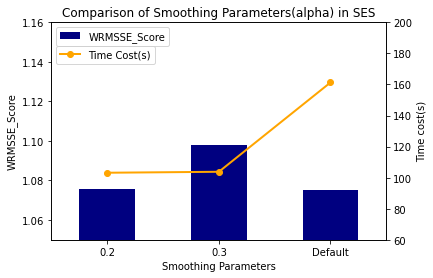

In [17]:
import matplotlib.pyplot as plt

width = .5 # width of a bar
h = pd.DataFrame({
    'WRMSSE_Score': [WRMSSE_Score1, WRMSSE_Score2, WRMSSE_Score3],
    'Time Cost': [Train_Time_1, Train_Time_2, Train_Time_3],
    })

ax1 = h[['WRMSSE_Score']].plot(kind='bar', color='navy', width = width)
ax1.legend(loc = 'upper left')
ax1.set_ylim([1.05, 1.16])

ax2 = ax1.twinx()
ax2.plot(ax1.get_xticks(),
         h[['Time Cost']].values, color='orange',
         linestyle='-', marker='o', linewidth=2.0)

ax1.set_xlabel("Smoothing Parameters")
ax1.set_ylabel("WRMSSE_Score")
ax2.set_ylabel("Time cost(s)")
# ax2.legend(loc = 'upper left')
ax2.legend(['Time Cost(s)'], loc = 'center left', bbox_to_anchor=(0, 0.6, 0.5, 0.5))

ax1.set_xticklabels(['0.2','0.3','Default'], rotation = 0)
ax2.set_ylim([60, 200])

plt.title("Comparison of Smoothing Parameters(alpha) in SES")
plt.show()

In [15]:
# Use default smoothing level value selected by model
FCAST = []
for i in tqdm(range(len(SalesTrain))):
    SESModel2 = SimpleExpSmoothing(Train_X.iloc[i]).fit()
    FCAST_i = SESModel2.forecast(28).values
    FCAST.append(FCAST_i)

100%|██████████| 30490/30490 [02:40<00:00, 189.65it/s]


In [16]:
FCAST_3 = np.array(FCAST_3)
FCAST = np.array(FCAST)

# Output the submission file

In [18]:
sample_submission = pd.read_csv('data/sample_submission.csv')
# Split the file to do parallel work 
Submission_1 = sample_submission.iloc[:30490,:]
Submission_2 = sample_submission.iloc[30490:,:]

print(sample_submission.columns)

Index(['id', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10',
       'F11', 'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28'],
      dtype='object')


In [19]:
F_Columns = [i for i in sample_submission.columns if 'F' in i]
for i in range(len(F_Columns)):
    Submission_1[F_Columns[i]] = FCAST_3[:,i]
    Submission_2[F_Columns[i]] = FCAST[:,i]

In [20]:
# Combine two parts to get the whole forcast result
Submission = pd.concat([Submission_1, Submission_2])
Submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.992402,0.992402,0.992402,0.992402,0.992402,0.992402,0.992402,0.992402,0.992402,...,0.992402,0.992402,0.992402,0.992402,0.992402,0.992402,0.992402,0.992402,0.992402,0.992402
1,HOBBIES_1_002_CA_1_validation,0.128630,0.128630,0.128630,0.128630,0.128630,0.128630,0.128630,0.128630,0.128630,...,0.128630,0.128630,0.128630,0.128630,0.128630,0.128630,0.128630,0.128630,0.128630,0.128630
2,HOBBIES_1_003_CA_1_validation,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,...,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011,0.816011
3,HOBBIES_1_004_CA_1_validation,2.014205,2.014205,2.014205,2.014205,2.014205,2.014205,2.014205,2.014205,2.014205,...,2.014205,2.014205,2.014205,2.014205,2.014205,2.014205,2.014205,2.014205,2.014205,2.014205
4,HOBBIES_1_005_CA_1_validation,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,...,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706,1.424706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.345106,0.345106,0.345106,0.345106,0.345106,0.345106,0.345106,0.345106,0.345106,...,0.345106,0.345106,0.345106,0.345106,0.345106,0.345106,0.345106,0.345106,0.345106,0.345106
60976,FOODS_3_824_WI_3_evaluation,0.201306,0.201306,0.201306,0.201306,0.201306,0.201306,0.201306,0.201306,0.201306,...,0.201306,0.201306,0.201306,0.201306,0.201306,0.201306,0.201306,0.201306,0.201306,0.201306
60977,FOODS_3_825_WI_3_evaluation,0.634659,0.634659,0.634659,0.634659,0.634659,0.634659,0.634659,0.634659,0.634659,...,0.634659,0.634659,0.634659,0.634659,0.634659,0.634659,0.634659,0.634659,0.634659,0.634659
60978,FOODS_3_826_WI_3_evaluation,1.097968,1.097968,1.097968,1.097968,1.097968,1.097968,1.097968,1.097968,1.097968,...,1.097968,1.097968,1.097968,1.097968,1.097968,1.097968,1.097968,1.097968,1.097968,1.097968


In [21]:
Submission.to_csv("submission.csv", index = False)